In [104]:
### 在这个file里，不会分训练集和测试集，所有数据都会用于本file的研究


### 参考资料： http://sofasofa.io/tutorials/shap_xgboost/

## 案例是回归，应该看二分类的案例 https://github.com/slundberg/shap/issues/29

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# generate two class dataset
data = pd.read_csv("stroke 21 variables for ML.csv")
data.head()

,stroke,NP,NC,MP,MC,BasoP,BasoC,EosP,EosC,MPV,...,RBC,RDW-DV,MCV,Glc,PLT,PDW,PCT,Hgb,Sex,Age
0,1,85.40,7.95,4.7,0.44,0.2,2,1.2,0.11,10.0,...,2.71,15.0,81.5,11.91,177,16.2,0.177,73,0,64
1,1,66.60,5.10,5.4,0.41,0.2,2,0.8,0.06,8.7,...,4.98,12.7,89.4,6.93,241,16.0,0.210,153,1,47
2,1,61.70,4.72,6.6,0.51,0.2,2,4.4,0.34,8.4,...,4.62,12.5,92.0,9.43,227,15.0,0.192,139,1,44
3,1,83.34,10.69,2.9,0.37,0.2,2,0.2,0.02,9.3,...,5.06,12.4,88.5,7.98,296,11.3,0.270,138,0,60
4,1,58.50,3.93,5.3,0.36,0.3,2,0.4,0.03,8.7,...,3.70,12.8,91.0,5.67,193,15.3,0.168,107,0,65


In [106]:
# Split target and features
X = data.drop(['stroke'],axis=1)
X
y = data['stroke'].values
y
print(X.shape)
print(y.shape)

(10476, 23)
(10476,)


In [107]:
# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# X_features = X
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [108]:
import shap

In [109]:
### Select 15 key features

### including 'Age','NC','LP','Hgb','MC','Glc','Sex','MCV','RDW_DV','RBC','NP','MCHC','MP','PCT','EosP'
cols = ['Age','NC','LP','Hgb','MC','Glc','Sex','MCV','RDW-DV','RBC','NP','MCHC','MP','PCT','EosP']


## XGBoost Classifier

from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.01, n_estimators=1000, silent=0, gamma=0.2, subsample=0.75, 
                       objective='binary:logistic', reg_alpha=1, reg_lambda=1,seed=27,
                      max_depth=7, min_child_weight=3)



model.fit(data[cols], y)

[16:13:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=27, silent=0,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [110]:
import shap
# model是在第1节中训练的模型
explainer = shap.TreeExplainer(model)

In [111]:
shap_values = explainer.shap_values(data[cols])
print(shap_values.shape)

(10476, 15)


In [112]:
#我们也可以获得在第2节中提到的模型的基线ybase。

#通过对比发现，我们可以确认基线值就是训练集的目标变量的拟合值的均值。

y_base = explainer.expected_value
print(y_base)

data['pred'] = model.predict(data[cols])
print(data['pred'].mean())

-0.105015114
0.46725849560901106


In [113]:
# 1 - 单个样本的SHAP值
# 比如我们挑选数据集中的第30位
j = 30
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['feature_value'] = data[cols].iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer

,feature,feature_value,shap_value
0,Age,71.000,0.396847
1,NC,3.400,-0.034189
2,LP,33.900,-0.272273
3,Hgb,144.000,-0.308637
4,MC,0.420,0.391294
5,Glc,8.070,-0.395351
6,Sex,1.000,0.432232
7,MCV,96.000,-0.334516
8,RDW-DV,12.100,0.201339
9,RBC,4.180,0.403382


In [114]:
#我们知道一个样本中各特征SHAP值的和加上基线值应该等于该样本的预测值。 我们可以做如下的验证。

print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
print('y_pred: %.2f'%(data['pred'].iloc[j]))

y_base + sum_of_shap_values: 0.89
y_pred: 1.00


In [115]:
#shap还提供极其强大的数据可视化功能。下图是对上面数据框的可视化。蓝色表示该特征的贡献是负数，红色则表示该特征的贡献是正数。
from matplotlib import cm

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[84], data[cols].iloc[84],plot_cmap="PkYg")

## plot_cmap="PkYg" 是调整颜色组合，调节成了粉色绿色组合

## visualize the first prediction's explanation with a Pink and Yellow-green color map

In [116]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6000], data[cols].iloc[6000],plot_cmap="PkYg")

In [117]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[8890], data[cols].iloc[8890],plot_cmap="PkYg")

In [118]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], data[cols].iloc[:1000,:],plot_cmap="PkYg")

In [119]:
shap.force_plot(explainer.expected_value, shap_values[4459:5499,:], data[cols].iloc[4459:5499,:],plot_cmap="DrDb")

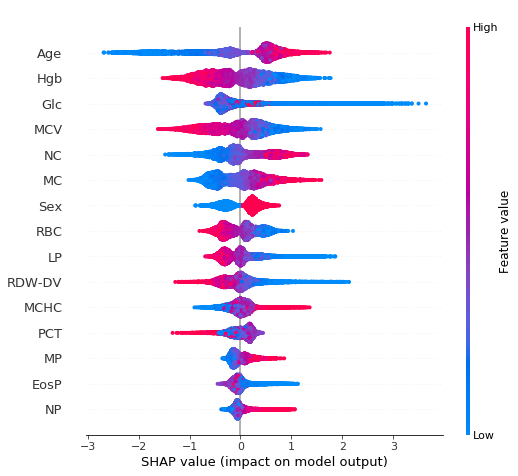

In [120]:
# 2- 对特征的总体分析
"""对特征的总体分析
除了能对单个样本的SHAP值进行可视化之外，还能对特征进行整体的可视化。

下图中每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小。

我们可以直观地看出潜力potential是一个很重要的特征，而且基本上是与身价成正相关的。年龄age也会明显影响身价，
蓝色点主要集中在SHAP小于0的区域，可见年纪小会降低身价估值，另一方面如果年纪很大，也会降低估值，甚至降低得更明显，
因为age这一行最左端的点基本上都是红色的。"""


shap.summary_plot(shap_values, data[cols])

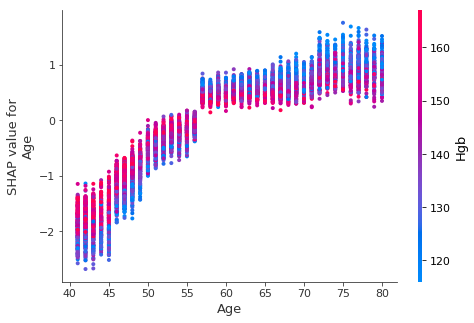

In [121]:
# 3 部分依赖图Partial Dependence Plot

## 注意！！ SHAP值为正数表示这个特征队最终的预测结果是正向推动，负数表示该特征对预测结果起到负面拉动作用。
###数值的绝对值越大，说明影响越大

shap.dependence_plot('Age', shap_values, data[cols], interaction_index='Hgb', show=False)
## 本研究是显示超过 57 岁，就是ischemic stroke的危险年龄 （纵坐标超过0来计算）

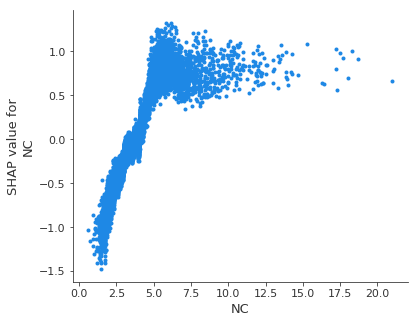

In [122]:
shap.dependence_plot('NC', shap_values, data[cols], interaction_index=None, show=False)

# NC 中性粒细胞计数的正常范围是 2.5 ~ 7.5 * 10^9 / L，本研究显示， 5.0是危险范围了

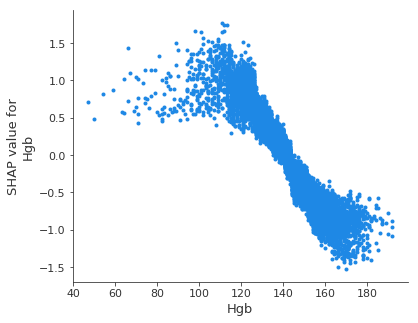

In [123]:
shap.dependence_plot('Hgb', shap_values, data[cols], interaction_index=None, show=False)
# 血红蛋白Hgb的正常含量是 男-120~165 g/L; 女-110~150 g/L

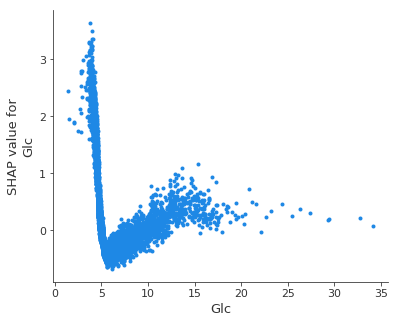

In [124]:
shap.dependence_plot('Glc', shap_values, data[cols], interaction_index=None, show=False)
# 血红蛋白Hgb的正常含量是 男-120~165 g/L; 女-110~150 g/L

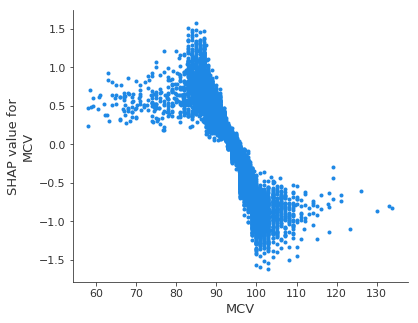

In [125]:
shap.dependence_plot('MCV', shap_values, data[cols], interaction_index=None, show=False)
# 血红蛋白Hgb的正常含量是 男-120~165 g/L; 女-110~150 g/L

In [ ]:
# full explanation of:  https://slundberg.github.io/shap/notebooks/plots/decision_plot.html